## 1. Involved vs Informational - Count of Occurence Analysis

_Ekaterina Levitskaya, Kara Kedrick, and Russell J Funk. "Investigating  writing style as a contributor to gender gaps in science and technology”. In: arXiv (2022). doi: 10.48550/arxiv.2204.13805. eprint: 2204.13805._

Involved features: emphasizing relationships
- pronouns (personal, possessive, wh-pronoun)
- non-phrasal coordination ("and")
- questions

Informational features: emphasizing facts
- determiners (predeterminers, wh-determiers, determiners) --> no stop word removal!
- verbs in past tense
- cardinal numbers

involved rate: (n_pron+n_and+n_q)/N_tokens * 100
informational rate: (n_det+n_pas+n_num)/N_tokens * 100
inv-inf-ratio: involved rate / informational rate

Method:
- segmenting into sentences unsing SaT model (https://arxiv.org/abs/2406.16678) and wtsplit https://github.com/segment-any-text/wtpsplit
- detecting questions using

Concatenating all prompts from on user first, then computing scores.
Otherwise, if computing scores per individual prompt, the repeated-measure structure gets ignored and within user variance gets mixed with between user variance, reducing statistical power


In [9]:
import sqlite3
import pandas as pd


from helpers.occurences import count_occurrences
from helpers.normalization import remove_punctuation_and_newlines, remove_capitalization

# conn = sqlite3.connect("../../giicg.db")
# prompts = pd.read_sql("Select * from expanded_prompts", conn)
#
# prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
# prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)


## Helpers

In [10]:
import spacy
import torch
import re
from wtpsplit import SaT
from transformers import AutoTokenizer, AutoModelForSequenceClassification


def load_spacy_lanuage_model() -> spacy.language.Language:
    try:
        return spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading missing model...")
        spacy.cli.download("en_core_web_sm")
        return spacy.load("en_core_web_sm")


def load_segmentation_model():
    return SaT("sat-3l-sm")


def load_question_detection_model():
    tokenizer = AutoTokenizer.from_pretrained("mrsinghania/asr-question-detection")
    model = AutoModelForSequenceClassification.from_pretrained("mrsinghania/asr-question-detection")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print("question model loaded")
    return tokenizer, model, device


def is_question(text: str, tokenizer, model, device) -> bool:
    if not isinstance(text, str) or text.strip() == "":
        return False
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    is_question = predicted_class == 1
    return is_question


def get_pronoun_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    pronouns = [token.text for token in doc if token.pos_ == "PRON"]
    print("prnouns:", pronouns)
    return len(pronouns)


def get_and_count(text: str) -> int:
    matches = re.findall(r'\band\b', text)
    count = len(matches)
    print("and count:", count)
    return count


def get_determiner_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.tag_ == "DT":  # Regular determiners (includes "the", "a", "my")
            count += 1
        elif token.tag_ == "PDT":  # Predeterminers (e.g., "all", "such")
            count += 1
        elif token.tag_ == "WDT":  # WH-determiners (e.g., "which", "whatever")
            count += 1
    print("determiner count:", count)
    return count


def get_verb_past_tense_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.lower_ == "could":
            continue  # Skip "could"
        if token.tag_ == "VBD" or token.tag_ == "VBN":
            count += 1
    print("verb past tense count:", count)
    return count


def get_number_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.pos_ == "NUM": count += 1
    print("number count:", count)
    return count


def get_question_count(text: str, tokenizer, model, device, sat) -> int:
    segmented = sat.split(text)
    count = 0
    for sentence in segmented:
        if is_question(sentence, tokenizer, model, device):
            count += 1
    print("question count:", count)
    return count


def compute_involved(text: str, tokenizer, model, device, sat, spacy_model) -> float:
    print("computing involved score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_pronoun = get_pronoun_count(text, spacy_model)
    print("n_pronoun:", n_pronoun)
    n_and = get_and_count(text)
    print("n_and:", n_and)
    n_question = get_question_count(text, tokenizer, model, device, sat)
    print("n_question:", n_question)
    score = ((n_pronoun + n_and + n_question) / len(tokens)) * 100
    print("involved score:", score)
    return score


def compute_informational(text: str, spacy_model) -> float:
    print("computing informational score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_determiner = get_determiner_count(text, spacy_model)
    n_verb_past_tense = get_verb_past_tense_count(text, spacy_model)
    n_number = get_number_count(text, spacy_model)
    score = ((n_determiner + n_verb_past_tense + n_number) / len(tokens)) * 100
    print("informational score:", score)
    return score


def compute_inv_inf_ratio(inv: float, inf: float) -> float:
    if inf == 0:
        return inv
    return inv / inf

tokenizer, question_model, device = load_question_detection_model()
spacy_model = load_spacy_lanuage_model()
sat = load_segmentation_model()

def compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model):
    prompts['n_tokens'] = prompts['conversational'].apply(lambda x: len(x.split()))

    prompts['n_det'] = prompts.apply(lambda row: (get_determiner_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_past_tense'] = prompts.apply(lambda row: (get_verb_past_tense_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_numbers'] = prompts.apply(lambda row: (get_number_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_pronouns'] = prompts.apply(lambda row: (get_pronoun_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_and'] = prompts.apply(lambda row: (count_occurrences(row['conversational'], "and", True)/row['n_tokens'])*100, axis=1)
    prompts['n_questions'] = prompts.apply(lambda row: (get_question_count(row['conversational'], tokenizer, question_model, device, sat)/row['n_tokens'])*100, axis=1)

    prompts['involved'] = prompts.apply(lambda row: (row['n_pronouns'] + row['n_and'] + row['n_questions']), axis=1)
    prompts['informational'] = prompts.apply(lambda row: (row['n_det'] + row['n_past_tense'] + row['n_numbers']), axis=1)
    prompts['inv_inf'] = prompts.apply(lambda row: compute_inv_inf_ratio(row['involved'], row['informational']) , axis=1)

    return prompts


question model loaded


## Compute scores on individual prompts

In [11]:
#scores = compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model)
#scores.to_sql("inv_inf_scores", conn,if_exists="replace", index=False)

## reimport

In [12]:
import sqlite3
import pandas as pd


from helpers.occurences import count_occurrences

conn = sqlite3.connect("../../giicg.db")
prompts = pd.read_sql("Select * from inv_inf_scores", conn)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language,n_tokens,n_det,n_past_tense,n_numbers,n_pronouns,n_and,n_questions,involved,informational,inv_inf
0,1,1,user,"parsing data from python iterator, how it coul...",parsing data from python iterator how it could...,,,Man (cisgender),6,en,17,0.000000,5.882353,0.000000,11.764706,0.000000,0.000000,11.764706,5.882353,2.000000
1,730,32,user,Write python function to do operations with in...,write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en,109,11.009174,4.587156,4.587156,9.174312,0.000000,0.000000,9.174312,20.183486,0.454545
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,write shortest tutorial on creating rag on ema...,,,Man (cisgender),6,en,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1135,55,user,what is FAISS,what is faiss,,,Man (cisgender),6,en,3,0.000000,0.000000,0.000000,33.333333,0.000000,33.333333,66.666667,0.000000,66.666667
4,1137,55,user,Transform given code to process large .mbox file,transform given code to process large mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en,8,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,12.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code i want to get nodes and edges ...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en,51,15.686275,1.960784,0.000000,13.725490,1.960784,0.000000,15.686275,17.647059,0.888889
749,1845,37,user,\n nun möchte ich judgement balancing m...,now i want to bring judgement balancing into t...,,,Woman (cisgender),29,de,51,13.725490,3.921569,1.960784,1.960784,7.843137,0.000000,9.803922,19.607843,0.500000
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,i do not see any change in the plot,,,Woman (cisgender),29,de,9,22.222222,0.000000,0.000000,11.111111,0.000000,0.000000,11.111111,22.222222,0.500000
751,1849,2,user,\n I am working on the problem of reconstru...,i am working on the problem of reconstruc...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en,23,13.043478,0.000000,0.000000,8.695652,0.000000,0.000000,8.695652,13.043478,0.666667


## Compute scores per user

In [13]:
user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()
)

user_prompts= user_prompts[user_prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_prompts = compute_scores(user_prompts, tokenizer, question_model, device, sat, spacy_model)

determiner count: 19
determiner count: 5
determiner count: 25
determiner count: 5
determiner count: 75
determiner count: 15
determiner count: 90
determiner count: 9
determiner count: 15
determiner count: 195
determiner count: 11
determiner count: 132
determiner count: 26
determiner count: 91
determiner count: 14
determiner count: 10
determiner count: 4
determiner count: 10
determiner count: 394
determiner count: 55
determiner count: 104
determiner count: 25
determiner count: 43
determiner count: 8
determiner count: 51
determiner count: 24
determiner count: 167
determiner count: 22
verb past tense count: 7
verb past tense count: 0
verb past tense count: 3
verb past tense count: 0
verb past tense count: 12
verb past tense count: 2
verb past tense count: 13
verb past tense count: 2
verb past tense count: 5
verb past tense count: 41
verb past tense count: 4
verb past tense count: 27
verb past tense count: 0
verb past tense count: 27
verb past tense count: 5
verb past tense count: 0
verb pa

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


prnouns: ['i', 'i', 'i', 'them', 'that', 'it', 'that', 'it', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'there', 'it', 'i', 'it', 'what', 'there', 'it', 'i', 'me', 'all', 'i', 'this', 'i', 'there', 'i', 'i', 'i', 'it', 'its', 'we', 'i', 'there', 'there', 'it', 'i', 'you', 'them', 'which', 'i', 'i', 'it', 'us', 'it', 'you', 'no', 'us', 'me', 'it', 'us', 'it', 'i', 'it', 'that', 'there', 'i', 'you', 'it', 'it', 'me', 'i', 'them', 'i', 'i', 'which', 'he', 'it', 'us', 'this', 'we', 'it', 'we', 'us', 'i', 'i', 'i', 'you', 'i', 'both', 'it', 'it', 'i', 'i', 'i', 'anything', 'i', 'i', 'they', 'i', 'them', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'you', 'what', 'i', 'i', 'it', 'i', 'that', 'i', 'it', 'they', 'i', 'it', 'this', 'i', 'i', 'it', 'i', 'it', 'i']
prnouns: ['my', 'my', 'i', 'i', 'me', 'i', 'all', 'it', 'i', 'this', 'my', 'i', 'everything', 'i', 'there', 'that']
question count: 3
question count: 0
question count: 9
question count: 0
question count: 13
question count: 2
question count: 12
question 

## Plot

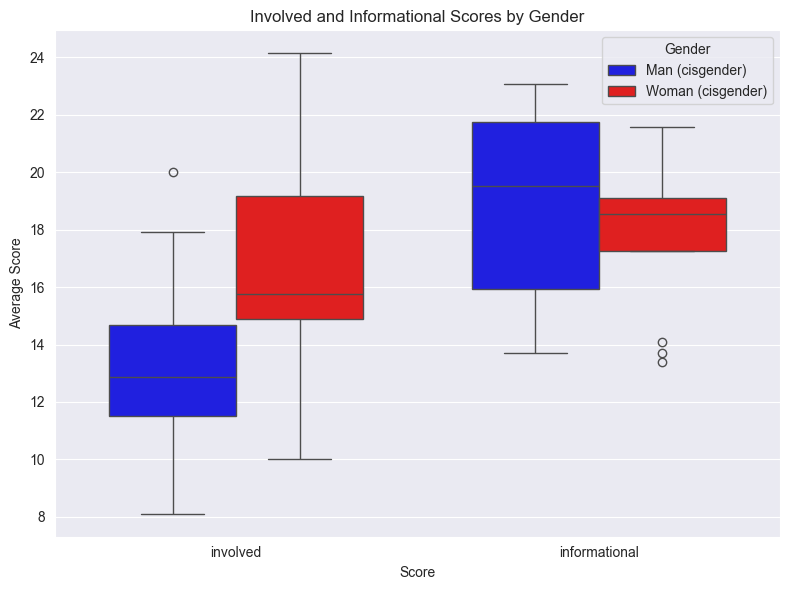

In [20]:
from helpers.statistical_tests import run_t_test_on_gender, compare_genders
import matplotlib.pyplot as plt
import seaborn as sns



#columns = ['involved', 'informational', 'inv_inf', 'n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions']
columns = ['involved', 'informational']

melted = user_prompts.melt(
    id_vars=['user_id', 'gender'],
    value_vars=columns,
    var_name='Score/Count',
    value_name='Normalized Rate'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Score/Count',
    y='Normalized Rate',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Involved and Informational Scores by Gender')
plt.ylabel('Average Score')
plt.xlabel('Score')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()




## Statistical Tests

In [15]:
from statsmodels.stats.multitest import multipletests

def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs= []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_genders(df, col, one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['m_female'])
        male_means.append(result['m_male'])
        female_stds.append(result['std_female'])
        male_stds.append(result['std_male'])
        n_females.append(result['n_female'])
        n_males.append(result['n_male'])
        nonzero_females.append(result['hits_female'])
        nonzero_males.append(result['hits_male']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results

In [16]:
from helpers.make_latex_table import create_latex_tables
results = groupwise_comparison_with_correction(user_prompts, ['inv_inf'], one_sided=True, direction="smaller")
results = results.sort_values(by="p_value", ascending=True)
results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,inv_inf,T-test,smaller,True,22.384083,-2.376051,0.013232,0.013232,0.979821,0.734303,0.303107,0.232699,13,15,13,15,-0.917798,Cohen's d,"[-1.72, -0.12]"


In [17]:
all_results = groupwise_comparison_with_correction(user_prompts, ['involved', 'informational'], one_sided=False)
all_results = all_results.sort_values(by="p_value", ascending=True)
create_latex_tables(results, "latex/inf_inv_all_stats.tex", "latex/inv_inf_all_means_hits.tex")
all_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,involved,T-test,two-sided,False,23.596821,-2.530255,0.018500,0.037001,16.761776,13.283527,3.904672,3.279242,13,15,13,15,-0.971171,Cohen's d,"[-1.84, -0.17]"
1,informational,Mann-Whitney U,greater,False,NaN,119.000000,0.333358,0.333358,18.543046,19.533851,2.531043,3.495770,13,15,13,15,0.220513,RBC,"[-0.31, 0.59]"


In [18]:
detailed_results = groupwise_comparison_with_correction(user_prompts, ['n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions'], one_sided=False)
detailed_results = detailed_results.sort_values(by="p_value", ascending=True)
detailed_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
5,n_questions,T-test,two-sided,False,24.797088,-1.947733,0.062854,0.338681,3.049098,1.845114,1.684647,1.567453,13,15,12,12,-0.742011,Cohen's d,"[-1.6, 0.01]"
4,n_and,Mann-Whitney U,greater,False,NaN,65.000000,0.140348,0.338681,2.030457,1.614087,1.570989,1.019704,13,15,13,13,-0.333333,RBC,"[-0.71, 0.09]"
0,n_det,T-test,two-sided,False,24.764689,1.415622,0.169340,0.338681,13.320852,14.450107,1.702054,2.490468,13,15,13,15,0.522175,Cohen's d,"[-0.24, 1.28]"
3,n_pronouns,T-test,two-sided,False,23.461288,-1.060886,0.299541,0.426605,11.296947,9.865517,3.847655,3.197848,13,15,13,15,-0.407498,Cohen's d,"[-1.23, 0.41]"
2,n_numbers,Mann-Whitney U,greater,False,NaN,77.000000,0.355504,0.426605,1.538945,1.086957,2.304416,1.003373,13,15,11,12,-0.210256,RBC,"[-0.64, 0.22]"
1,n_past_tense,Mann-Whitney U,greater,False,NaN,112.500000,0.502053,0.502053,2.237136,2.996670,1.305635,2.625305,13,15,10,12,0.153846,RBC,"[-0.3, 0.55]"


In [19]:
combined = pd.concat([results, all_results], axis=0)
create_latex_tables(results, "latex/inf_inv_stats.tex", "latex/inv_inf_means_hits.tex")
combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,inv_inf,T-test,smaller,True,22.384083,-2.376051,0.013232,0.013232,0.979821,0.734303,0.303107,0.232699,13,15,13,15,-0.917798,Cohen's d,"[-1.72, -0.12]"
0,involved,T-test,two-sided,False,23.596821,-2.530255,0.018500,0.037001,16.761776,13.283527,3.904672,3.279242,13,15,13,15,-0.971171,Cohen's d,"[-1.84, -0.17]"
1,informational,Mann-Whitney U,greater,False,NaN,119.000000,0.333358,0.333358,18.543046,19.533851,2.531043,3.495770,13,15,13,15,0.220513,RBC,"[-0.31, 0.59]"
